# Lab 4: Song Classification, Part 1

Welcome to Lab 4! Over the next two labs, you will build your own song classifer using k-nearest neighbors.

Lab 4 is part 1 of the investigation. Lab 5 is part 2 of the investigation. Lab 5 will be released next week.

You will build a classifier that guesses whether a song is hip-hop or country, using only the numbers of times words appear in the song's lyrics.  By the end of the project, you should know how to:

1. Clean and organize a dataset used to test a machine learning model
2. Build a k-nearest neighbors classifier
3. Test a classifier on data

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect. You can add any additional names or functions you want to the provided cells. 

To get started, load `datascience`, `numpy`, `plots`, and `okgrade`.

In [1]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter('ignore', UserWarning)

# These lines load the tests.
from okgrade import grade

# 1. The Dataset

Our dataset is a table of songs, each with a name, an artist, and a genre.  We'll be trying to predict each song's genre.

The only attributes we will use to predict the genre of a song are its lyrics. In particular, we have a list of just under 5,000 words that might occur in a song.  For each song, our dataset tells us the frequency with which each of these words occurs in that song. All words have been converted to lowercase.

Run the cell below to read the `lyrics` table. **It may take up to a minute to load.**

In [15]:
lyrics = Table.read_table('lyrics.csv')
lyrics.where("Title", "In Your Eyes").select(0, 1, 2, 3, 4, 5, "like", "love")
# lyrics.where("Title", "In Your Eyes")

Title,Artist,Genre,i,the,you,like,love
In Your Eyes,Alison Krauss,Country,0.107143,0,0.0297619,0.0119048,0.0595238


That cell prints a few columns of the row for the country song ["In Your Eyes" by Alison Krauss](http://www.azlyrics.com/lyrics/alisonkrauss/inyoureyes.html).  The song contains 168 words. The word "like" appears twice:  $\frac{2}{168} \approx 0.0119$ of the words in the song. The word "love" appears 10 times: $\frac{10}{168} \approx 0.0595$ of the words. The word "the" doesn't appear at all.

Our dataset doesn't contain all information about a song.  For example, it doesn't describe the order of words in the song, let alone the melody, instruments, or rhythm. Nonetheless, you may find that word frequencies alone are sufficient to build an accurate genre classifier.

All titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [16]:
title_index = lyrics.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    lyrics.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

For example, the fastest way to find the frequency of "love" in the song *In Your Eyes* is to access the `'love'` item from its row.

In [17]:
row_for_title('In Your Eyes').item('love')

0.05952381

** Question 1.1 ** <br/>
Set `expected_row_sum` to the number that you expect will result from summing all proportions in each row, excluding the first three columns.

In [18]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1.0

In [19]:
grade("tests/q1_1.py")

Run the cell below to generate a histogram of the actual row sums. It should confirm your answer above, perhaps with a small amount of error.

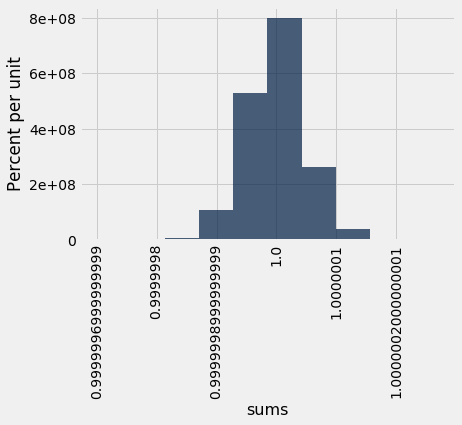

In [20]:
# Run this cell to display a histogram of the sums of proportions in each row.
# This computation might take up to a minute; you can skip it if it's too slow.
Table().with_column('sums', lyrics.drop([0, 1, 2]).apply(sum)).hist(0)

This dataset was extracted from the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/). Specifically, we are using the complementary datasets from [musiXmatch](http://labrosa.ee.columbia.edu/millionsong/musixmatch) and [Last.fm](http://labrosa.ee.columbia.edu/millionsong/lastfm). 

The counts of common words in the lyrics for all of these songs are provided by the musiXmatch dataset (called a bag-of-words format). We converted the words to lowercase, removed the naughty ones, and converted the counts to frequencies.

The Last.fm dataset contains multiple tags for each song in the Million Song Dataset. Some of the tags are genre-related, such as "pop", "rock", "classic", etc.  To construct the `Genre` column, we first extracted songs with Last.fm tags that included the words "country", or both "hip" and "hop". These songs were then cross-referenced with the musiXmatch dataset, and only songs with musixMatch lyrics were placed into our dataset. 

In [21]:
print('Words with frequencies:', lyrics.drop('Title', 'Artist', 'Genre').num_columns)
print('Songs with genres:', lyrics.num_rows)

Words with frequencies: 4817
Songs with genres: 1721


## 1.1. Word Stemming
The columns other than Title, Artist, and Genre in the `lyrics` table are all words that appear in some of the songs in our dataset.  Some of those names have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each song.  

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [22]:
# Just run this cell.
vocab_mapping = Table.read_table('mxm_reverse_mapping_safe.csv')
stemmed = np.take(lyrics.labels, np.arange(3, len(lyrics.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1106))

Stem,Word
devant,devant
devast,devastation
devil,devil
devot,devotion
devour,devour
dew,dew


** Question 1.1.1 ** <br/>
Assign `unchanged` to the **percentage** of words in `vocab_table` that are the same as their stemmed form (such as "devour" above).

*Hint:* Try using `where` and comparing the number of rows in a table of only unchanged vocabulary with the number of rows in `vocab_table`.

In [42]:
?Table.sort

In [61]:
percent_unchanged = vocab_table.where('Stem', are.equal_to, 'Word').num_rows / vocab_table.num_rows * 100
print(round(percent_unchanged, 2), 'percent are unchanged')

# percent_unchanged.take[11:20]

71.77 percent are unchanged


In [62]:
grade("tests/q1_1_1.py")

** Question 1.1.2 ** <br/>
Assign `stemmed_message` to the stemmed version of the word "message".

In [71]:
# Set stemmed_message to the stemmed version of "message" (which
# should be a string).  Use vocab_table.
stemmed_message = vocab_table.where('Word', are.equal_to('message')).row(0).item(0)
stemmed_message

'messag'

In [72]:
grade("tests/q1_1_2.py")

** Question 1.1.3 ** <br/>
Assign `unstemmed_singl` to the word in `vocab_table` that has "singl" as its stemmed form. (*Note that multiple English words may stem to "singl", but only one example appears in `vocab_table`.*)

In [81]:
# Set unstemmed_singl to the unstemmed version of "singl" (which
# should be a string).
unstemmed_singl = vocab_table.where('Stem', are.equal_to('singl')).where('Word', are.not_equal_to('singl')).row(0).item(1)
unstemmed_singl

'single'

In [82]:
grade("tests/q1_1_3.py")

## 1.2. Splitting the dataset
We're going to use our `lyrics` dataset for two purposes.

1. First, we want to *train* song genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no songs that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [ ]:
# Here we have defined the proportion of our data
# that we want to designate for training as 11/16ths
# of our total dataset.  5/16ths of the data is
# reserved for testing.

training_proportion = 11/16

num_songs = lyrics.num_rows
num_train = int(num_songs * training_proportion)
num_valid = num_songs - num_train

train_lyrics = lyrics.take(np.arange(num_train))
test_lyrics = lyrics.take(np.arange(num_train, num_songs))

print("Training: ",   train_lyrics.num_rows, ";",
      "Test: ",       test_lyrics.num_rows)

Run the code below to display a horizontal bar chart with two bars that show the proportion of Country songs in each dataset.  We use the function `country_proportion` to help us create the bar chart.

In [ ]:
def country_proportion(table):
    """Return the proportion of songs in a table that have the Country genre."""
    return table.where('Genre', are.equal_to('Country')).num_rows / table.num_rows

Table().with_columns(
        'Dataset', make_array('Training', 'Test'),
        'Proportion of Country', make_array(country_proportion(train_lyrics), country_proportion(test_lyrics)))\
       .barh('Dataset')

# 2. K-Nearest Neighbors - a Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each song is *the proportion of times a particular word appears in the lyrics*, and the labels are two music genres: hip-hop and country.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_lyrics` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a  song

In k-NN, we classify a song by finding the `k` songs in the *training set* that are most similar according to the features we choose. We call those songs with similar features the *nearest neighbors*.  The k-NN algorithm assigns the song to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each song.  The features we will use are the proportions of the words "like" and "love" in the lyrics.  Taking the song "In Your Eyes" (in the test set), 0.0119 of its words are "like" and 0.0595 are "love". This song appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two songs is the straight-line distance between them when we plot their features in a scatter diagram. This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 - (y_1 - y_2)^2}$.

For example, in the song *Insane in the Brain* (in the training set), 0.0203 of all the words in the song are "like" and 0 are "love".  Its distance from *In Your Eyes* on this 2-word feature set is $\sqrt{(0.0119 - 0.0203)^2 + (0.0595 - 0)^2} \approx 0.06$.  (If we included more or different features, the distance could be different.)

A third song, *Sangria Wine* (in the training set), is 0.0044 "like" and 0.0925 "love".

The function below creates a plot to display the "like" and "love" features of a test song and some training songs. As you can see in the result, *In Your Eyes* is more similar to *Sangria Wine* than to *Insane in the Brain*.

In [ ]:
# Just run this cell.

def plot_with_two_features(test_song, training_songs, x_feature, y_feature):
    """Plot a test song and training songs using two features."""
    test_row = row_for_title(test_song)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['Unknown'],
            'Title',   [test_song]
        )
    for song in training_songs:
        row = row_for_title(song)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), song])
    distances.scatter(x_feature, y_feature, colors='Color', labels='Title', s=200)
    
training = ["Sangria Wine", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

** Question 2.1.1 ** <br/>
Compute the distance between the two country songs, *In Your Eyes* and *Sangria Wine*, using the `like` and `love` features only.  Assign it the name `country_distance`.

**Note:** If you have a row object, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

**Note 2:** You can quickly get the row from the `lyrics` table via `row_for_title`. For example, if "Insane In The Brain" is the song title, then `row_for_title("Insane In The Brain")` is the row object for this song.

In [ ]:
in_your_eyes = row_for_title("In Your Eyes")
sangria_wine = row_for_title("Sangria Wine")
country_distance = ...
country_distance

In [ ]:
grade("tests/q2_1_1.py")

The `plot_with_two_features` function can show the positions of several training songs. Below, we've added one that's even closer to *In Your Eyes*.

In [ ]:
training = ["Sangria Wine", "Lookin' for Love", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

** Question 2.1.2 ** <br/>
Complete the function `distance_two_features` that computes the Euclidean distance between any two songs, using two features. The last two lines call your function to show that *Lookin' for Love* is closer to *In Your Eyes* than *Insane In The Brain*. 

In [ ]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two songs with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = ...
    row1 = ...
    ...

for song in make_array("Lookin' for Love", "Insane In The Brain"):
    song_distance = distance_two_features(song, "In Your Eyes", "like", "love")
    print(song, 'distance:\t', song_distance)

In [ ]:
grade("tests/q2_1_2.py")

** Question 2.1.3 ** <br/>
Define the function `distance_from_in_your_eyes` so that it works as described in its documentation.

In [ ]:
def distance_from_in_your_eyes(title):
    """The distance between the given song and "In Your Eyes", based on the features "like" and "love".
    
    This function takes a single argument:
      title: A string, the name of a song.
    """
    ...

In [ ]:
grade("tests/q2_1_3.py")

#### Question 2.1.4
Using the features `"like" and "love"`, what are the names and genres of the 7 songs in the **training set** closest to "In Your Eyes"?  To answer this question, make a table named `close_songs` containing those 7 songs with columns `"Title"`, `"Artist"`, `"Genre"`, `"like"`, and `"love"`, as well as a column called `"distance"` that contains the distance from "In Your Eyes".  The table should be **sorted in ascending order by `distance`**.

In [ ]:
# The staff solution took 4 lines.
close_songs = ...
close_songs

In [ ]:
grade("tests/q2_1_4.py")

** Question 2.1.5 ** <br/>
Define the function `most_common` so that it works as described in its documentation below.

In [ ]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    ...

# Calling most_common on your table of 7 nearest neighbors classifies
# "In Your Eyes" as a country song, 4 votes to 3.
most_common('Genre', close_songs)

In [ ]:
grade("tests/q2_1_5.py")

Congratulations are in order -- you've classified your first song!

## Submission

You're finished with lab 4! We'll pick off from here next week in lab 5 to finish our song classifier.

In order to successfully submit your assignment, follow these steps...
- **IMPORTANT** Before you do anything, **Save and Checkpoint** from the `File` menu. Please do this first before running the cell below,
- **run all the tests and verify that they all pass** (the next cell has a shortcut for that), 
- **Review the notebook one last time, we will be grading the final state of your notebook** If you make any changes, please **Save and Checkpoint** again.

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import glob
from okgrade.notebook import grade_notebook
if not globals().get('__OKGRADE__', False):
    display(grade_notebook('lab04.ipynb', sorted(glob.glob('tests/q*.py'))))